t=o is defined by the first picture number, for example "C001H001S0003000005" means that t=0 is for frame 5.
Mf.skip_photos() always keeps the first photo, thus even if you skip photos with Mf.skip_photos() for "Multi_openPIV" it is gereented that the first frame is frame 5 and it is defined as t=0.

In [1]:
import My_functions as Mf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot - PTV')
pic_folder = os.path.join(Mf.select_directory())



frames_per_second = Mf.read_data_from_cihx(pic_folder, return_number = True, return_int=True) # fps
dt = 1/frames_per_second
print('frame per second =', frames_per_second)
print('date of expirement : ', Mf.read_data_from_cihx(pic_folder, '<date>'))
round_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'Record number - {round_number}')

Mf.create_directory(save_folder)
Mf.copy_file(Mf.files_in_folder(pic_folder, 'cihx', True)[0], save_folder)

frame per second = 60
date of expirement :  2024/1/8
Record number - 3
the folder c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output has been created


scaling factor from cihx

In [3]:
unit = Mf.read_data_from_cihx(pic_folder, '<distanceUnit>')
scaling_factor = 1/Mf.read_data_from_cihx(pic_folder, '<sizeOfPixel>', return_number = True) #[pixel/mm]
if 'mm' in unit:
    scaling_factor *= 1000
scaling_factor #[pixel/m]

2962.9629629629626

Choose the experment number - that will be used to determine the excel row

In [4]:
experiment_number = 1

choose origin

In [5]:
origin = [0, 1024]
# origin = Mf.choose_origin_napari(Mf.find_pictures(pic_folder)[0])

all the files in the directory

In [6]:
sphere_location_pixel = Mf.track_object_series(pic_folder, fft=True,
												image_number = 53,
												sphere_location = [469, 157],
												Object_data = [[435, 123], [435, 196], [505, 196], [505, 123]],
												PTV_data = [[375, 0], [375, 1024], [608, 1024], [608, 0]])

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame 
Change the contrasnt to enable manual high_pass_filter


												image_number = 40,
												sphere_location = [459, 152],
												Object_data = [[416, 109], [416, 199], [508, 199], [508, 109]],
												PTV_data = [[375, 0], [375, 1024], [608, 1024], [608, 0]])


In [7]:
alala = np.reshape(np.arange(1, len(sphere_location_pixel)+1), (-1,1))
sphere_location_pixel = np.array(sphere_location_pixel)
sphere_location_pixel_with_frame = np.concatenate((sphere_location_pixel, alala), axis=1)

display the sphere with its location

In [8]:
Mf.display_images_with_points_napari(pic_folder, sphere_location_pixel, title = 'Verify sphere location')

892

In [9]:
sphere_location_pixel = np.array(sphere_location_pixel)
#needed? if not del sphere_location_pixel_with_time
sphere_location_pixel_with_time = np.column_stack((np.arange(0, len(sphere_location_pixel[:,1])*dt, dt), sphere_location_pixel[:,1]))

from pixel to meter

In [10]:
sphere_location_meter = Mf.transform_coordinates_physical(sphere_location_pixel, pic_folder, scaling_factor, origin_point=origin)
sphere_location_meter_with_time = np.column_stack((np.arange(0, len(sphere_location_meter[:,1])*dt, dt), sphere_location_meter[:,1]))

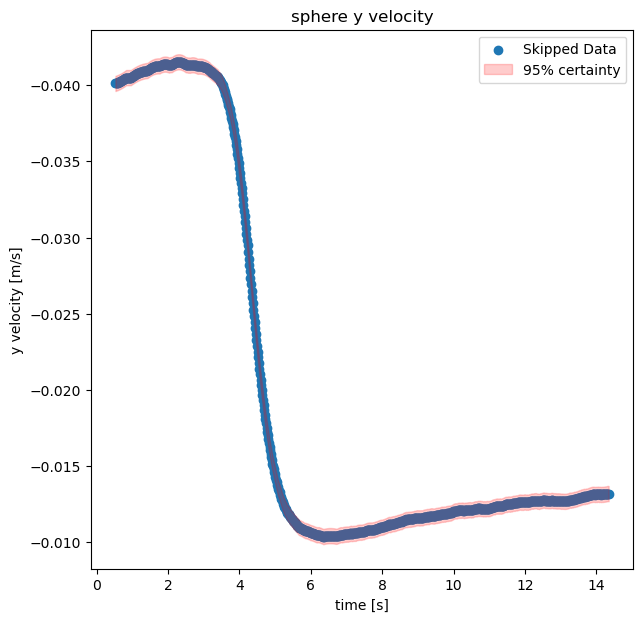

In [11]:
wanted_velocity_uncertainty = 0.001/2 #[m/s]
location_uncertainty_pixel = 2 #[pixel]
neighboring_points = Mf.neighboring_points_from_velocity_acceptable_error(velocity_acceptable_error = wanted_velocity_uncertainty, window_size = 0.3, dt = dt, location_uncertainty_pixel = location_uncertainty_pixel)
y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted = Mf.calc_velocity_least_squares_lines_with_times(sphere_location_meter[:,1], dt=dt, neighboring_points=neighboring_points)


# y_location_meter_cutted = Mf.location_with_respect_to_velocity(sphere_location_meter[:,1], dt=dt, velocity_acceptable_error=wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)


# # add first and last data points
# y_location_meter_cutted = np.append(np.append([sphere_location_meter[:,1][0]], y_location_meter_cutted, axis = 0), [sphere_location_meter[:,1][-1]], axis = 0)
# y_velocity_meter_cutted = np.append(np.append([y_velocity_meter_cutted[0]], y_velocity_meter_cutted, axis = 0), [y_velocity_meter_cutted[-1]], axis = 0)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y velocity')
plt.scatter(y_times_cutted, y_velocity_meter_cutted, label='Skipped Data')
plt.fill_between(y_times_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')
# print(len(y_times_cutted), len(y_location_meter_cutted))


ax.set_xlabel('time [s]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()
# plt.savefig(os.path.join(save_folder, 'sphere velocity PTV.svg'), transparent=True, bbox_inches='tight')

# velocitys_meter = Mf.full_list_from_interpolate_between_points(y_location_meter_cutted, y_velocity_meter_cutted, sphere_location_meter[:,1])
# print(len(velocitys_meter), len(sphere_location_meter[:,1]))

Acceleration

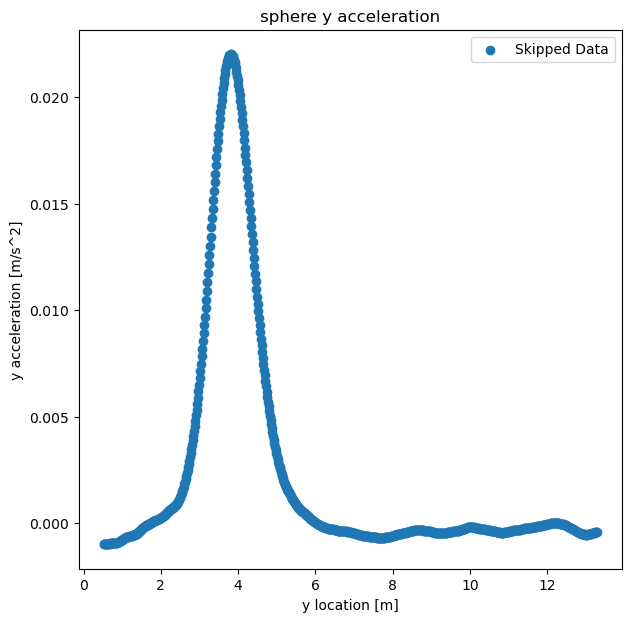

In [12]:
y_location_acccel_cutted, y_accel_meter_cutted = Mf.calc_acceleration_least_squares_lines_with_times(y_location_meter_cutted, y_velocity_meter_cutted, dt=dt, neighboring_points=neighboring_points)
# y_location_acccel_cutted, y_accel_meter_cutted = Mf.calc_acceleration_least_squares_lines(sphere_location_meter[:,1], velocitys_meter, dt=dt, velocity_acceptable_error = wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)
y_accel_meter_cutted = np.array(y_accel_meter_cutted)



fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y acceleration')
plt.scatter(y_location_acccel_cutted, y_accel_meter_cutted, label='Skipped Data')


ax.set_xlabel('y location [m]')
ax.set_ylabel('y acceleration [m/s^2]')
plt.legend()
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.show()

Bouncing is a problem to extend the velocity function.

In [13]:
postivie_vel = -y_velocity_meter_cutted
if min(postivie_vel) < 0:
    print('bouncing, its a problem for velocity function, need to plot velocity vs time')

Load Data from excel

In [14]:
row_number = experiment_number - 1
experiment_date = Mf.read_data_from_cihx(pic_folder, '<date>')
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, sphere_rho, sphere_type, Interface_center \
      = Mf.load_data_for_demintionless_number(experiment_date = experiment_date, row_number=row_number)

continue FIX TIME fromm here

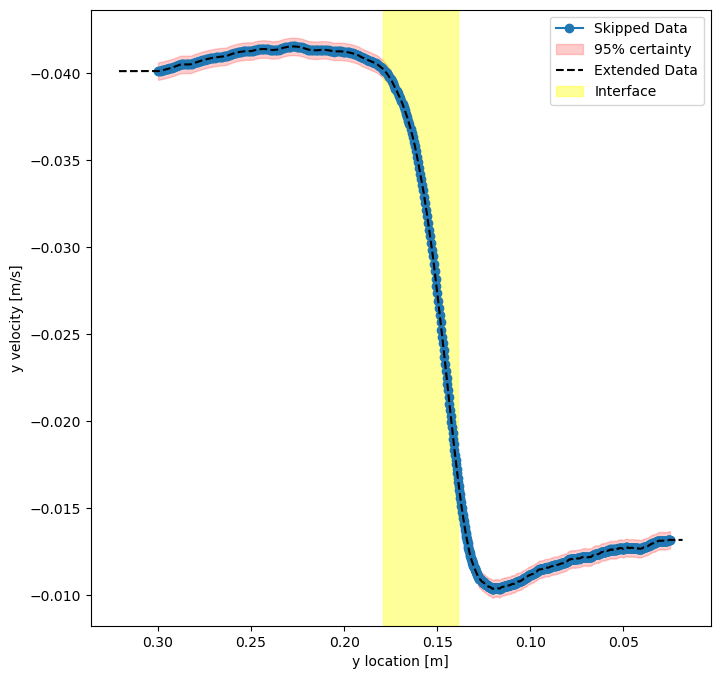

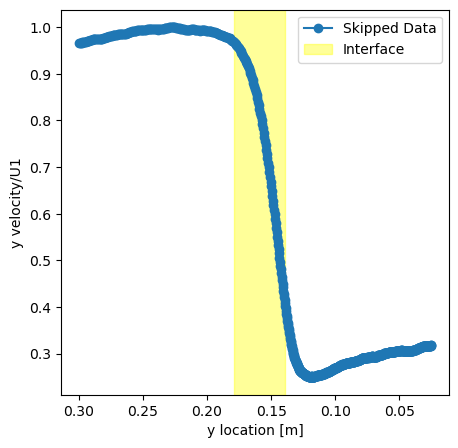

In [15]:
import matplotlib.patches as patches

if min(postivie_vel) >= 0:
    velocitys_meter = Mf.full_list_from_interpolate_between_points(y_location_meter_cutted, y_velocity_meter_cutted, sphere_location_meter[:,1])
else: 
    velocitys_meter = y_velocity_meter_cutted
    
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(y_location_meter_cutted, y_velocity_meter_cutted, 'o-', label='Skipped Data')
plt.fill_between(y_location_meter_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')
if min(postivie_vel) >= 0:
    plt.plot(sphere_location_meter[:,1], velocitys_meter, '--', color = 'black', label='Extended Data')


# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(y_location_meter_cutted, -y_velocity_meter_cutted/max(postivie_vel), 'o-', label='Skipped Data')


# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity/U1')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

In [16]:
from scipy.constants import g
upper_velocity = -min(y_velocity_meter_cutted)
lower_velocity = -y_velocity_meter_cutted[-1]
min_velocity = -max(y_velocity_meter_cutted)

upper_Re = upper_velocity*sphere_diameter/upper_viscosity
lower_Re = lower_velocity*sphere_diameter/lower_viscosity
Brunt_number = np.sqrt(2*g/Interface_thickness*(lower_density-upper_density)/(lower_density+upper_density))
upper_Fr = upper_velocity/(Brunt_number*sphere_diameter)
lower_Fr = lower_velocity/(Brunt_number*sphere_diameter)

choosing the state.

taking 10 precent clearance

In [17]:
postivie_vel = -y_velocity_meter_cutted
if min(postivie_vel) < 0:
    state = 'bouncing'
else:
    if min(postivie_vel)*1.1 <= postivie_vel[-1]:
        state = 'minimum'
    else:
        state = 'no - minimum'
print(f'does "{state}" make sense?')

does "minimum" make sense?


In [18]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'''experiment_date = {experiment_date}
run_number = {run_number}
sphere_type = {sphere_type}
sphere_diameter = {sphere_diameter}
sphere_rho = {sphere_rho}
upper_density = {upper_density}
lower_density = {lower_density}
upper_viscosity = {upper_viscosity}
lower_viscosity = {lower_viscosity}
upper_Re = {upper_Re}
lower_Re = {lower_Re}
upper_Fr = {upper_Fr}
lower_Fr = {lower_Fr}
Brunt_number = {Brunt_number}
state = {state}''')

experiment_date = 2024/1/8
run_number = 3
sphere_type = P2
sphere_diameter = 0.01
sphere_rho = 1110
upper_density = 1097.8
lower_density = 1105.9
upper_viscosity = 1.4270666666666667e-06
lower_viscosity = 1.582533333333333e-06
upper_Re = 291.04659311654405
lower_Re = 83.3171476924373
upper_Fr = 3.0938208961942104
lower_Fr = 0.9821450827500485
Brunt_number = 1.342491713060831
state = minimum


In [23]:
print(f'In {datetime.date.today().strftime("%Y/%m/%d")} {datetime.datetime.now().strftime("%H:%M:%S")}')
file_path = os.path.join(save_folder, 'data_from_PTV.pkl')
Mf.save_pickle(file_path, [y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted])


dimensionless_numbers_path = os.path.join(save_folder, 'dimensionless_numbers_PTV.pkl')
Mf.save_pickle(dimensionless_numbers_path, [upper_Re, lower_Re, upper_Fr, lower_Fr, Brunt_number, state])

run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
dimensionless_numbers_path_excel = os.path.join(parent_folder, 'Dimensionless Numbers PTV.xlsx')


In 2024/01/16 11:37:43
The file data_from_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file data_from_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file dimensionless_numbers_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


In [19]:
fhd

NameError: name 'fhd' is not defined

# Save
y axis is positive upwards.

+ sphere_location_meter - the sphere aboslute location in meters [m] relative to bottom left corner, the origin.
+ velocitys_meter - sphere velocity in [m/s] SI units


In [ ]:
# print(f'In {datetime.date.today().strftime("%Y/%m/%d")} {datetime.datetime.now().strftime("%H:%M:%S")}')
# file_path = os.path.join(save_folder, 'data_from_PTV.pkl')
# Mf.save_pickle(file_path, [sphere_location_meter, velocitys_meter])

# dimensionless_numbers_path = os.path.join(save_folder, 'dimensionless_numbers_PTV.pkl')
# Mf.save_pickle(dimensionless_numbers_path, [upper_Re, lower_Re, upper_Fr, lower_Fr, Brunt_number, state])

# run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
# dimensionless_numbers_path_excel = os.path.join(parent_folder, 'Dimensionless Numbers PTV.xlsx')


# calculated_sphere_rho = Mf.find_sphere_rho(sphere_diameter, upper_viscosity, upper_density, upper_velocity)

# xls = pd.ExcelFile(dimensionless_numbers_path_excel)
# selected_sheet_name = xls.sheet_names[0]
# df = pd.read_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name)

# new_data = {'Data Processing Date': datetime.date.today().strftime("%Y/%m/%d"), 'Data Processing Hour': datetime.datetime.now().strftime("%H:%M:%S"),
#             'Experiment Date': experiment_date, 'Record number': run_number, 'Sphere Type': sphere_type, 'Experiment number': experiment_number,
#             'Sphere Diameter [m]': sphere_diameter, 'Sphere density [kg/m^3]': sphere_rho, 'Upper density [kg/m^3]': upper_density,
#             'Lower density [kg/m^3]': lower_density, 'Upper viscosity [m^2/sec]': upper_viscosity, 'Lower viscosity [m^2/sec]': lower_viscosity,
#             'Upper velocity [m/s]': upper_velocity, 'Lower velocity [m/s]': lower_velocity,'Minimum velocity [m/s]': min_velocity,
#             'Upper Re': upper_Re, 'Lower Re': lower_Re, 'Upper Fr': upper_Fr, 'Lower Fr': lower_Fr, 'Brunt Number': Brunt_number, 'State': state,
#             'Calculated sphere density [kg/m^3]': calculated_sphere_rho, 'Interface width [m]': Interface_thickness,
#             'Full Trajectory Time [sec]': len(Mf.find_pictures(pic_folder))/frames_per_second, 'Index': len(df)}

# df.loc[len(df)] = new_data
# df.to_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name, index=False)
# xls.close()

# print(f'The file {os.path.basename(dimensionless_numbers_path_excel)} has been updated at: {os.path.dirname(dimensionless_numbers_path_excel)}')

In 2024/01/12 12:14:49
The file data_from_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file dimensionless_numbers_PTV.pkl has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


The file Dimensionless Numbers PTV.xlsx has been updated at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis
